In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Membaca CSV dengan delimiter yang benar
df = pd.read_csv("BBRI.csv")  # Menyesuaikan delimiter

# Menampilkan hasil
print(df)  # Cek apakah kolom sudah benar

# Konversi kolom 'Date' menjadi format datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)


            Date  Close  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0       2/1/2020   4410         NaN         NaN         NaN         NaN   
1       3/1/2020   4420         NaN         NaN         NaN         NaN   
2       6/1/2020   4370         NaN         NaN         NaN         NaN   
3       7/1/2020   4400         NaN         NaN         NaN         NaN   
4       8/1/2020   4380         NaN         NaN         NaN         NaN   
...          ...    ...         ...         ...         ...         ...   
1167  25/10/2024   4770         NaN         NaN         NaN         NaN   
1168  28/10/2024   4760         NaN         NaN         NaN         NaN   
1169  29/10/2024   4700         NaN         NaN         NaN         NaN   
1170  30/10/2024   4710         NaN         NaN         NaN         NaN   
1171  31/10/2024   4800         NaN         NaN         NaN         NaN   

      Unnamed: 6  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4   

In [3]:
# Memeriksa data untuk nilai null
print("\nCek Nilai Null:")
print(df.isnull().sum())


Cek Nilai Null:
Close            0
Unnamed: 2    1172
Unnamed: 3    1172
Unnamed: 4    1172
Unnamed: 5    1172
Unnamed: 6    1172
dtype: int64


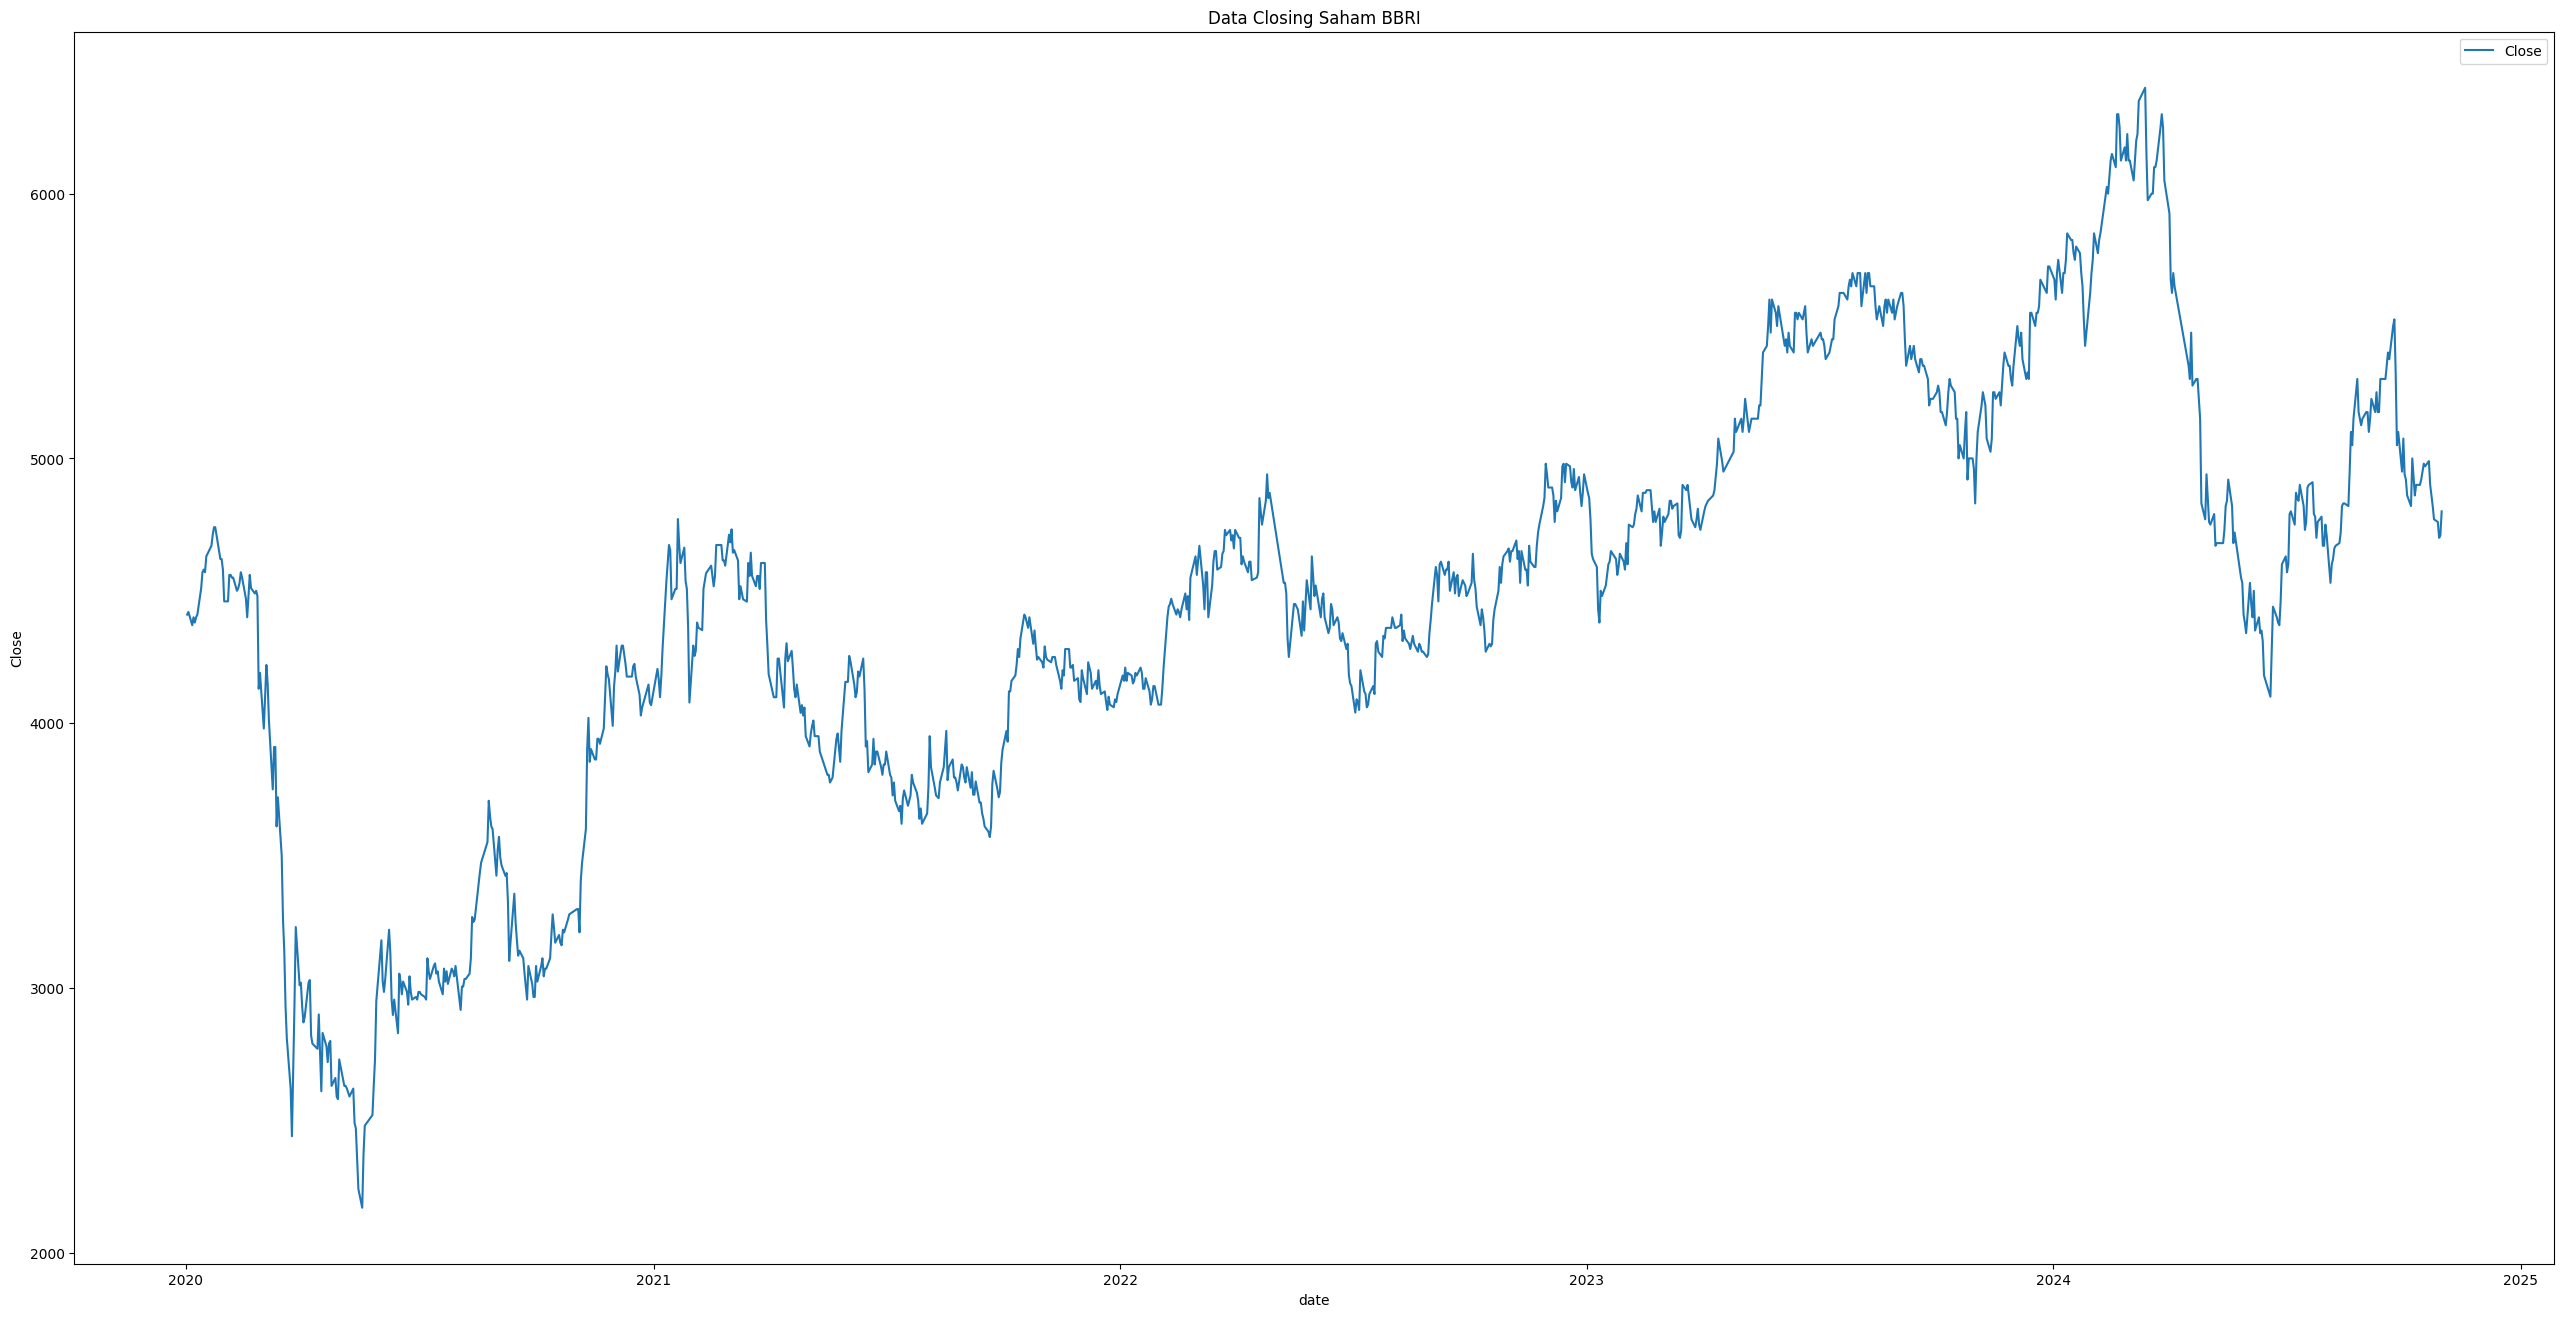

In [4]:
# Visualisasi data historis
plt.figure(figsize=(32, 16))
plt.plot(df['Close'], label='Close')
plt.title('Data Closing Saham BBRI')
plt.xlabel('date')
plt.ylabel('Close')
plt.legend()
plt.show()

In [5]:
# Menormalisasi data dengan MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df[['Close']].values)
print("\nData Normalisasi:")
print(data_scaled)


Data Normalisasi:
[[0.52955083]
 [0.53191489]
 [0.52009456]
 ...
 [0.59810875]
 [0.60047281]
 [0.62174941]]


In [6]:
# Membagi data menjadi latih dan uji
training_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:training_size], data_scaled[training_size:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (937, 1)
test_data:  (235, 1)


In [7]:
# Fungsi untuk membuat dataset time-series
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        dataX.append(dataset[i:(i + time_step), 0]) # Ambil time_step data sebagai input
        dataY.append(dataset[i + time_step, 0]) # Data berikutnya sebagai prediksi
    return np.array(dataX), np.array(dataY)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)

Shape X_train: (877, 60)
Shape X_test: (175, 60)
Shape y_train: (877,)
Shape y_test: (175,)


In [8]:
# Mengubah bentuk input untuk LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)

Shape X_train: (877, 60, 1)
Shape X_test: (175, 60, 1)


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import numpy as np
import tensorflow as tf
import random
import os

# 1. Set seed untuk NumPy
np.random.seed(42)

# 2. Set seed untuk Python random
random.seed(42)

# 3. Set seed untuk TensorFlow
tf.random.set_seed(42)

# 4. Memastikan hasil tetap sama saat dijalankan ulang
os.environ['PYTHONHASHSEED'] = '42'

# 5. Konfigurasi deterministik untuk TensorFlow (opsional tapi bisa membantu)
tf.config.experimental.enable_op_determinism()

# 2. Membuat dan Melatih Model LSTM

model = Sequential([
    LSTM(50, activation='tanh', recurrent_activation="sigmoid", input_shape=(time_step, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.1310 - val_loss: 0.0167
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 12/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0

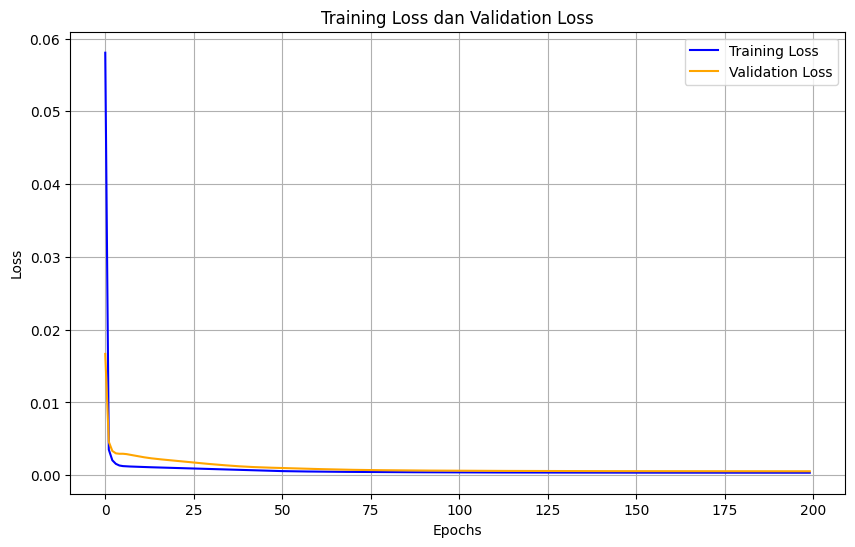

In [10]:
# Visualisasi Training Loss dan Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training Loss dan Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# 3. Ambil Bobot Awal
lstm_weights = model.layers[0].get_weights()
W, U, b = lstm_weights[0], lstm_weights[1], lstm_weights[2]

# 4. Pecah Bobot ke Setiap Gate
def split_weights(W, U, b):
    W_i, W_f, W_c, W_o = np.split(W, 4, axis=1)  # Bobot input ke gate
    U_i, U_f, U_c, U_o = np.split(U, 4, axis=1)  # Bobot hidden ke gate
    b_i, b_f, b_c, b_o = np.split(b, 4)  # Bias setiap gate
    return (W_i, U_i, b_i), (W_f, U_f, b_f), (W_c, U_c, b_c), (W_o, U_o, b_o)

(Wi, Ui, bi), (Wf, Uf, bf), (Wc, Uc, bc), (Wo, Uo, bo) = split_weights(W, U, b)

# 5. Simpan Bobot ke dalam Excel
target_file = "LSTM_Weights.xlsx"
with pd.ExcelWriter(target_file) as writer:
    pd.DataFrame(Wi).to_excel(writer, sheet_name="Wi")
    pd.DataFrame(Ui).to_excel(writer, sheet_name="Ui")
    pd.DataFrame(bi).to_excel(writer, sheet_name="bi")

    pd.DataFrame(Wf).to_excel(writer, sheet_name="Wf")
    pd.DataFrame(Uf).to_excel(writer, sheet_name="Uf")
    pd.DataFrame(bf).to_excel(writer, sheet_name="bf")

    pd.DataFrame(Wc).to_excel(writer, sheet_name="Wc")
    pd.DataFrame(Uc).to_excel(writer, sheet_name="Uc")
    pd.DataFrame(bc).to_excel(writer, sheet_name="bc")

    pd.DataFrame(Wo).to_excel(writer, sheet_name="Wo")
    pd.DataFrame(Uo).to_excel(writer, sheet_name="Uo")
    pd.DataFrame(bo).to_excel(writer, sheet_name="bo")

print(f"\n== File {target_file} telah disimpan! ==")



== File LSTM_Weights.xlsx telah disimpan! ==


In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf

# 1. Fungsi Sigmoid dan Tanh untuk Perhitungan Manual
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# 2. Hitung Forward Pass

def lstm_forward(X, Wi, Ui, bi, Wf, Uf, bf, Wo, Uo, bo, Wc, Uc, bc):
    batch_size, time_steps, input_dim = X.shape
    hidden_dim = Ui.shape[0]  # Jumlah unit LSTM

    h_t = np.zeros((batch_size, hidden_dim))  # Hidden state awal
    c_t = np.zeros((batch_size, hidden_dim))  # Cell state awal

    for t in range(time_steps):
        x_t = X[:, t, :]  # Ambil input per time step

        # Hitung setiap gate
        i_t = sigmoid(np.dot(x_t, Wi) + np.dot(h_t, Ui) + bi)  # Input gate
        f_t = sigmoid(np.dot(x_t, Wf) + np.dot(h_t, Uf) + bf)  # Forget gate
        o_t = sigmoid(np.dot(x_t, Wo) + np.dot(h_t, Uo) + bo)  # Output gate
        c_tilde = tanh(np.dot(x_t, Wc) + np.dot(h_t, Uc) + bc)  # Candidate cell state

        # Update cell state dan hidden state
        c_t = f_t * c_t + i_t * c_tilde
        h_t = o_t * tanh(c_t)

    return i_t, f_t, o_t, c_tilde, h_t, c_t

# Ambil batch pertama
batch_sample = X_train[:32]

# Hitung forward pass
i_t, f_t, o_t, c_tilde, h_t, c_t = lstm_forward(
    batch_sample, Wi, Ui, bi, Wf, Uf, bf, Wo, Uo, bo, Wc, Uc, bc
)

# Hitung Output dari Dense Layer
dense_weights = model.layers[1].get_weights()
Wd, bd = dense_weights[0], dense_weights[1]
dense_output = np.dot(h_t, Wd) + bd

# Simpan Hasil Forward Pass ke dalam Excel
target_file = "LSTM_Forward_Pass.xlsx"
with pd.ExcelWriter(target_file) as writer:
    pd.DataFrame(i_t).to_excel(writer, sheet_name="Input_Gate")
    pd.DataFrame(f_t).to_excel(writer, sheet_name="Forget_Gate")
    pd.DataFrame(o_t).to_excel(writer, sheet_name="Output_Gate")
    pd.DataFrame(c_tilde).to_excel(writer, sheet_name="Cell_Candidate")
    pd.DataFrame(h_t).to_excel(writer, sheet_name="Hidden_State")
    pd.DataFrame(c_t).to_excel(writer, sheet_name="Cell_State")
    pd.DataFrame(dense_output).to_excel(writer, sheet_name="Dense_Output")

print(f"\n== File {target_file} telah disimpan! ==")



== File LSTM_Forward_Pass.xlsx telah disimpan! ==


In [13]:
import numpy as np
import tensorflow as tf
import pandas as pd

# Pastikan model sudah dilatih
assert 'model' in globals(), "Model belum dilatih! Jalankan pelatihan terlebih dahulu."

# 1. Definisikan fungsi loss
loss_fn = tf.keras.losses.MeanSquaredError()

# 2. Gunakan GradientTape untuk menghitung gradien
def compute_gradients(model, X_batch, y_batch):
    with tf.GradientTape() as tape:
        predictions = model(X_batch, training=True)
        loss = loss_fn(y_batch, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    return gradients

# 3. Ambil batch pertama untuk perhitungan gradien
X_batch, y_batch = X_train[:32], y_train[:32]
gradients = compute_gradients(model, X_batch, y_batch)

# 4. Pecah gradien ke setiap gate
W_grad, U_grad, b_grad = gradients[0].numpy(), gradients[1].numpy(), gradients[2].numpy()

def split_gradients(W, U, b):
    dWi, dWf, dWc, dWo = np.split(W, 4, axis=1)
    dUi, dUf, dUc, dUo = np.split(U, 4, axis=1)
    dbi, dbf, dbc, dbo = np.split(b, 4)
    return (dWi, dUi, dbi), (dWf, dUf, dbf), (dWc, dUc, dbc), (dWo, dUo, dbo)

(dWi, dUi, dbi), (dWf, dUf, dbf), (dWc, dUc, dbc), (dWo, dUo, dbo) = split_gradients(W_grad, U_grad, b_grad)

# 5. Simpan hasil gradien ke dalam file Excel
file_name = "LSTM_Gradients.xlsx"
with pd.ExcelWriter(file_name) as writer:
    pd.DataFrame(dWi).to_excel(writer, sheet_name="dWi")
    pd.DataFrame(dUi).to_excel(writer, sheet_name="dUi")
    pd.DataFrame(dbi).to_excel(writer, sheet_name="dbi")

    pd.DataFrame(dWf).to_excel(writer, sheet_name="dWf")
    pd.DataFrame(dUf).to_excel(writer, sheet_name="dUf")
    pd.DataFrame(dbf).to_excel(writer, sheet_name="dbf")

    pd.DataFrame(dWc).to_excel(writer, sheet_name="dWc")
    pd.DataFrame(dUc).to_excel(writer, sheet_name="dUc")
    pd.DataFrame(dbc).to_excel(writer, sheet_name="dbc")

    pd.DataFrame(dWo).to_excel(writer, sheet_name="dWo")
    pd.DataFrame(dUo).to_excel(writer, sheet_name="dUo")
    pd.DataFrame(dbo).to_excel(writer, sheet_name="dbo")

print(f"\n== File {file_name} telah disimpan! ==")



== File LSTM_Gradients.xlsx telah disimpan! ==


In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd

# Adam Optimizer Parameters
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Inisialisasi m dan v untuk Adam
m_W, v_W = np.zeros_like(W), np.zeros_like(W)
m_U, v_U = np.zeros_like(U), np.zeros_like(U)
m_b, v_b = np.zeros_like(b), np.zeros_like(b)

t = 1  # Iterasi pertama Adam

def adam_update(param, grad, m, v, t, lr=learning_rate, beta1=beta1, beta2=beta2, eps=epsilon):
    """Fungsi untuk memperbarui parameter menggunakan Adam optimizer"""
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)
    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)
    param -= lr * m_hat / (np.sqrt(v_hat) + eps)
    return param, m, v

# Update bobot dan bias untuk setiap gate
W_new, m_W, v_W = adam_update(W, W_grad, m_W, v_W, t)
U_new, m_U, v_U = adam_update(U, U_grad, m_U, v_U, t)
b_new, m_b, v_b = adam_update(b, b_grad, m_b, v_b, t)

# Pecah bobot baru ke dalam setiap gate
(Wi_new, Ui_new, bi_new), (Wf_new, Uf_new, bf_new), (Wc_new, Uc_new, bc_new), (Wo_new, Uo_new, bo_new) = split_weights(W_new, U_new, b_new)

# Simpan bobot baru ke dalam file Excel
updated_weights_file = "LSTM_Updated_Weights.xlsx"
with pd.ExcelWriter(updated_weights_file) as writer:
    pd.DataFrame(Wi_new).to_excel(writer, sheet_name="Wi_New")
    pd.DataFrame(Ui_new).to_excel(writer, sheet_name="Ui_New")
    pd.DataFrame(bi_new).to_excel(writer, sheet_name="bi_New")

    pd.DataFrame(Wf_new).to_excel(writer, sheet_name="Wf_New")
    pd.DataFrame(Uf_new).to_excel(writer, sheet_name="Uf_New")
    pd.DataFrame(bf_new).to_excel(writer, sheet_name="bf_New")

    pd.DataFrame(Wc_new).to_excel(writer, sheet_name="Wc_New")
    pd.DataFrame(Uc_new).to_excel(writer, sheet_name="Uc_New")
    pd.DataFrame(bc_new).to_excel(writer, sheet_name="bc_New")

    pd.DataFrame(Wo_new).to_excel(writer, sheet_name="Wo_New")
    pd.DataFrame(Uo_new).to_excel(writer, sheet_name="Uo_New")
    pd.DataFrame(bo_new).to_excel(writer, sheet_name="bo_New")

print(f"\n== Bobot dan bias baru telah disimpan di {updated_weights_file}! ==")



== Bobot dan bias baru telah disimpan di LSTM_Updated_Weights.xlsx! ==


In [15]:
# 3. Evaluasi Model
# Membuat prediksi
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Mengembalikan data ke skala aslinya
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Menghitung metrik evaluasi untuk data latih dan uji
train_rmse = math.sqrt(mean_squared_error(y_train_original, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_original, test_predict))
train_mse = mean_squared_error(y_train_original, train_predict)
test_mse = mean_squared_error(y_test_original, test_predict)
train_mape = np.mean(np.abs((y_train_original - train_predict) / y_train_original)) * 100
test_mape = np.mean(np.abs((y_test_original - test_predict) / y_test_original)) * 100

print("\nEvaluasi Model:")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train MAPE: {train_mape}%")
print(f"Test MAPE: {test_mape}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Evaluasi Model:
Train RMSE: 78.00921232002028
Test RMSE: 99.41671820581408
Train MSE: 6085.437206790004
Test MSE: 9883.683858814244
Train MAPE: 1.4384711437742175%
Test MAPE: 1.4926158897927393%


In [16]:
# Mengambil bobot dari layer LSTM
lstm_layer = model.layers[0]  # Lapisan LSTM
weights = lstm_layer.get_weights()


# Memisahkan bobot menjadi Kernel (W), Recurrent weights (U), dan Bias (b)
W = weights[0]  # Kernel weights (input to gates)
U = weights[1]  # Recurrent weights (hidden state to gates)
b = weights[2]  # Bias

# Menampilkan ukuran setiap bobot
print("Shape of W (bobot input):", W.shape)
print("Shape of U (Bobot hidden state):", U.shape)
print("Shape of b (Bias):", b.shape)

# Memisahkan bobot untuk setiap gate
units = lstm_layer.units  # Jumlah unit (neurons) dalam LSTM

W_f, W_i, W_c, W_o = W[:, :units], W[:, units:2*units], W[:, 2*units:3*units], W[:, 3*units:]
U_f, U_i, U_c, U_o = U[:, :units], U[:, units:2*units], U[:, 2*units:3*units], U[:, 3*units:]
b_f, b_i, b_c, b_o = b[:units], b[units:2*units], b[2*units:3*units], b[3*units:]


Shape of W (bobot input): (1, 200)
Shape of U (Bobot hidden state): (50, 200)
Shape of b (Bias): (200,)


In [17]:
# Menampilkan bobot untuk Forget Gate
print("W_f (Bobot Input untuk Forget Gate):\n", W_f)
print("U_f (Bobot hidden state untuk Forget Gate):\n", U_f)
print("b_f (Bias untuk Forget Gate):\n", b_f)

print("Shape of W_f:", W_f.shape)
print("Shape of U_f:", U_f.shape)
print("Shape of b_f:", b_f.shape)

W_f (Bobot Input untuk Forget Gate):
 [[ 0.19147085  0.1353996  -0.07391914  0.14676273 -0.23215204  0.07252362
   0.12501274 -0.11945111  0.03741695  0.07677921 -0.04119308  0.02474235
   0.19728038 -0.00149943  0.01364305  0.2192908  -0.18750301 -0.11471838
  -0.01055387  1.0942361  -0.12567598  0.17645538  0.12984231  0.03464426
   0.19343944 -0.09483922  0.04113693  0.0867181   0.11641773 -0.08063523
  -0.06467626  0.1936499  -0.11038817  0.02603768 -0.12721586 -0.19186088
   0.13696624 -0.0434823   0.1011221   0.0501743  -0.17689465  0.22414175
  -0.02817425  0.0473363   0.1969227   0.03518675  0.03545272 -0.12026692
  -0.07843735  0.15909724]]
U_f (Bobot hidden state untuk Forget Gate):
 [[ 0.03115635 -0.03199511  0.04656999 ... -0.03477026 -0.08778989
  -0.01934247]
 [ 0.03703491  0.03208379 -0.02766039 ... -0.15283364  0.006144
   0.1740319 ]
 [-0.06408351 -0.02634031  0.01525922 ... -0.01468193 -0.06675047
  -0.02631304]
 ...
 [ 0.01776435 -0.03892709  0.0350145  ...  0.135738

In [18]:
# Menampilkan bobot untuk Input Gate
print("W_i (Bobot Input untuk Input Gate):\n", W_i)
print("U_i (Bobot hidden state untuk Input Gate):\n", U_i)
print("b_i (Bias untuk Input Gate):\n", b_i)
print("Shape of W_i:", W_i.shape)
print("Shape of U_i:", U_i.shape)
print("Shape of b_i:", b_i.shape)

W_i (Bobot Input untuk Input Gate):
 [[ 6.44953847e-02  4.84574810e-02 -1.97279528e-01 -1.34847119e-01
   4.56504412e-02  1.20506935e-01 -4.49575000e-02 -6.75830618e-02
  -1.28046378e-01 -1.44521117e-01  1.13241673e-01  1.39873341e-01
  -1.50439609e-02  8.50121230e-02 -5.48782237e-02  1.44212425e-01
  -7.80296326e-02 -5.78385070e-02  1.16262905e-01 -1.34708807e-01
   8.99341553e-02  1.67575896e-01  1.24686934e-01 -3.42492498e-02
   1.22614801e-01 -1.29960150e-01  1.94672555e-01  1.06511042e-01
   7.12813437e-02 -1.04383543e-01 -8.02566409e-02  1.81008652e-01
  -1.34632051e-01 -2.50827186e-02 -1.29518315e-01 -1.61510006e-01
   1.60589516e-01  1.69019923e-01  6.60702959e-02  1.03281029e-02
  -7.59027753e-05  1.79142758e-01  1.16330339e-02 -8.72492939e-02
   1.38344288e-01  4.69279289e-03  1.17912829e-01  1.03526525e-01
   1.15561299e-02 -1.48561642e-01]]
U_i (Bobot hidden state untuk Input Gate):
 [[ 0.0476108   0.07987919 -0.15982622 ... -0.02014145  0.03291699
  -0.10462979]
 [-0.11787

In [19]:
# Menampilkan bobot untuk Cell State
print("W_c (Bobot Input untuk Cell State):\n", W_c)
print("U_c (Bobot hidden state untuk Cell State):\n", U_c)
print("b_c (Bias untuk Cell State):\n", b_c)
print("Shape of W_c:", W_c.shape)
print("Shape of U_c:", U_c.shape)
print("Shape of b_c:", b_c.shape)

W_c (Bobot Input untuk Cell State):
 [[ 0.21973024  0.18974556  0.03101665 -0.07808842 -0.05970401  0.12697025
  -0.0861906   0.01672187  0.0790109   0.02837544 -0.15898892  0.1181867
  -0.06160121  0.13828702  0.02021733 -0.1363122   0.10758066 -0.15978697
  -0.07469978 -0.82121676  0.03962832 -0.19979832 -0.10008918  0.22719076
   0.05539922 -0.12553367  0.17694217 -0.19001585  0.10400538 -0.13951437
   0.1356205  -0.1055483  -0.01805804 -0.0352003  -0.02927929 -0.09138329
  -0.04675383  0.00155485  0.19527742 -0.09641881 -0.12630102 -0.2181124
   0.06108208  0.18310873  0.15606943  0.08125531 -0.03945257  0.12911412
   0.0013073  -0.12965658]]
U_c (Bobot hidden state untuk Cell State):
 [[-0.1708131   0.01801642  0.01466814 ... -0.04884239  0.10420697
   0.01772349]
 [-0.02680168  0.0030728   0.13364126 ...  0.05606341 -0.06139322
  -0.00884641]
 [ 0.01577152  0.07304516 -0.08712725 ...  0.02854528  0.05776641
   0.00269494]
 ...
 [ 0.1419289  -0.06117668  0.11443865 ...  0.02582335

In [20]:
# Menampilkan bobot untuk Output Gate
print("W_o (Bobot Input untuk Output Gate):\n", W_o)
print("U_o (Bobot hidden state untuk Output Gate):\n", U_o)
print("b_o (Bias untuk Output Gate):\n", b_o)
print("Shape of W_o:", W_o.shape)
print("Shape of U_o:", U_o.shape)
print("Shape of b_o:", b_o.shape)

W_o (Bobot Input untuk Output Gate):
 [[ 0.11932889  0.30772135 -0.16991764 -0.02278117 -0.27241144 -0.15218842
   0.06886332 -0.0950873   0.19782004  0.1701579   0.18705298  0.11675641
  -0.08450373  0.14393666  0.189538    0.06823023  0.10780931 -0.08403865
   0.11707769  0.890146   -0.01320285  0.13594359  0.0115579   0.17935605
   0.16761675  0.21513674  0.09791312  0.00737898  0.27083454 -0.13520317
   0.03608872  0.21216936 -0.11657454  0.01961814 -0.14242059 -0.12660438
   0.1275404   0.00224037 -0.00330542 -0.06578796 -0.00610993  0.26118848
   0.0460544   0.22388846  0.2546328   0.2769706   0.01615832 -0.03485697
   0.23863854  0.14224586]]
U_o (Bobot hidden state untuk Output Gate):
 [[ 0.01498064  0.11967599  0.1149003  ... -0.07349408 -0.08149979
   0.08465292]
 [ 0.0932292   0.02832788 -0.06464729 ... -0.03382701 -0.08060323
  -0.03775809]
 [-0.050198    0.01382182  0.02779733 ... -0.02956841 -0.18364248
  -0.11784196]
 ...
 [ 0.03537251 -0.0200575  -0.04176809 ... -0.1469

In [21]:
# Menyimpan semua bobot dan bias ke dalam satu file Excel
with pd.ExcelWriter("LSTM_Weights_Biases.xlsx", engine="openpyxl") as writer:
    pd.DataFrame(W_f).to_excel(writer, sheet_name="W_f (Forget Gate)", index=False)
    pd.DataFrame(W_i).to_excel(writer, sheet_name="W_i (Input Gate)", index=False)
    pd.DataFrame(W_c).to_excel(writer, sheet_name="W_c (Candidate Gate)", index=False)
    pd.DataFrame(W_o).to_excel(writer, sheet_name="W_o (Output Gate)", index=False)

    pd.DataFrame(U_f).to_excel(writer, sheet_name="U_f (Forget Gate)", index=False)
    pd.DataFrame(U_i).to_excel(writer, sheet_name="U_i (Input Gate)", index=False)
    pd.DataFrame(U_c).to_excel(writer, sheet_name="U_c (Candidate Gate)", index=False)
    pd.DataFrame(U_o).to_excel(writer, sheet_name="U_o (Output Gate)", index=False)

    pd.DataFrame(b_f).to_excel(writer, sheet_name="b_f (Forget Gate)", index=False)
    pd.DataFrame(b_i).to_excel(writer, sheet_name="b_i (Input Gate)", index=False)
    pd.DataFrame(b_c).to_excel(writer, sheet_name="b_c (Candidate Gate)", index=False)
    pd.DataFrame(b_o).to_excel(writer, sheet_name="b_o (Output Gate)", index=False)

print("Semua bobot dan bias berhasil disimpan dalam satu file Excel!")

Semua bobot dan bias berhasil disimpan dalam satu file Excel!


In [22]:
# === Ambil Bobot & Bias Dense Layer ===
dense_weights, dense_bias = model.layers[1].get_weights()

print("W_dense: ", dense_weights)
print("b_dense: ", dense_bias)

W_dense:  [[ 0.281146  ]
 [ 0.14832507]
 [ 0.02272989]
 [ 0.06692834]
 [ 0.16349132]
 [ 0.19814308]
 [ 0.19852616]
 [ 0.24879685]
 [-0.14964533]
 [ 0.11243182]
 [-0.32040048]
 [ 0.18947843]
 [-0.10080767]
 [-0.04194718]
 [ 0.01264523]
 [-0.37167   ]
 [-0.12855422]
 [-0.07448288]
 [ 0.21404567]
 [-0.750159  ]
 [ 0.05962872]
 [-0.1067344 ]
 [ 0.25879404]
 [ 0.28931737]
 [-0.24512787]
 [-0.09877285]
 [ 0.3388348 ]
 [-0.3603896 ]
 [ 0.3871071 ]
 [-0.04715235]
 [ 0.24037415]
 [-0.06419487]
 [-0.23928496]
 [-0.22133298]
 [ 0.2152427 ]
 [ 0.23496279]
 [-0.24970223]
 [-0.07753873]
 [ 0.33605206]
 [-0.00946011]
 [ 0.01805958]
 [-0.2255525 ]
 [ 0.1464795 ]
 [ 0.25447157]
 [ 0.09741365]
 [ 0.29985076]
 [-0.28069812]
 [-0.24322182]
 [ 0.17190044]
 [-0.24386647]]
b_dense:  [0.01351915]


In [23]:
import numpy as np

# === Fungsi aktivasi ===
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# === Gunakan X_test asli ===
print("Shape X_test:", X_test.shape)  # Pastikan ukurannya (175, 90, 1)

# === Inisialisasi hidden state & cell state ===
h_t = np.zeros((175, 50))
C_t = np.zeros((175, 50))

# === Forward Pass X_test Asli ===
for t in range(60):  # Looping tiap timestep
    x_t = X_test[:, t, :]  # Ambil input di timestep t → (175, 1)

    # Forget gate
    f_t = sigmoid(np.dot(x_t, W_f) + np.dot(h_t, U_f) + b_f.T)  # (175, 50)

    # Input gate
    i_t = sigmoid(np.dot(x_t, W_i) + np.dot(h_t, U_i) + b_i.T)  # (175, 50)

    # Candidate cell state
    C_tilde_t = tanh(np.dot(x_t, W_c) + np.dot(h_t, U_c) + b_c.T)  # (175, 50)

    # Cell state update
    C_t = f_t * C_t + i_t * C_tilde_t  # (175, 50)

    # Output gate
    o_t = sigmoid(np.dot(x_t, W_o) + np.dot(h_t, U_o) + b_o.T)  # (175, 50)

    # Hidden state update
    h_t = o_t * tanh(C_t)  # (175, 50)

    # === Hitung Output Dense Layer ===
    y_pred = np.dot(h_t, dense_weights) + dense_bias  # (175, 1)



# === Print hasil akhir ===
print("Forget Gate (f_t):", f_t)
print("Input Gate (i_t):", i_t)
print("Candidate Cell State (C_tilde_t):", C_tilde_t)
print("Cell State (C_t):", C_t)
print("Output Gate (o_t):", o_t)
print("Hidden State (h_t):", h_t)
print("\nOutput Dense Layer (y_pred):", y_pred)

print("\nUkuran Forget Gate (f_t):", f_t.shape)
print("Ukuran Input Gate (i_t):", i_t.shape)
print("Ukuran Candidate Cell State (C_tilde_t):", C_tilde_t.shape)
print("Ukuran Cell State (C_t):", C_t.shape)
print("Ukuran Output Gate (o_t):", o_t.shape)
print("Ukuran Hidden State (h_t):", h_t.shape)  # (175, 50)
print("Ukuran Output Dense Layer (y_pred):", y_pred.shape)  # (175, 1)


Shape X_test: (175, 60, 1)
Forget Gate (f_t): [[0.58292371 0.50933565 0.48097567 ... 0.4414044  0.4325761  0.5759781 ]
 [0.58477829 0.50992322 0.48030032 ... 0.43987457 0.43155515 0.5776898 ]
 [0.58480268 0.50904446 0.48039399 ... 0.4395067  0.43117011 0.57785831]
 ...
 [0.5659464  0.51136412 0.48463589 ... 0.45271505 0.45188836 0.56126727]
 [0.56508877 0.51126757 0.48486081 ... 0.45327552 0.45273032 0.56055381]
 [0.5648461  0.51176926 0.4848274  ... 0.45344898 0.45338391 0.56031804]]
Input Gate (i_t): [[0.7293806  0.70712462 0.67686712 ... 0.72872616 0.7053589  0.68621393]
 [0.72942398 0.70678242 0.67534315 ... 0.72883336 0.70504729 0.68511728]
 [0.72889156 0.70596027 0.67554996 ... 0.72805509 0.70454592 0.68530791]
 ...
 [0.730188   0.71435177 0.69049858 ... 0.72782157 0.71286803 0.69676479]
 [0.73017502 0.71456458 0.69115613 ... 0.72765177 0.71322358 0.69739492]
 [0.73039587 0.71502709 0.69119905 ... 0.72788447 0.71367358 0.69745271]]
Candidate Cell State (C_tilde_t): [[ 0.12167984 

In [24]:
# === Simpan hasil ke dalam Excel ===
file_path = "hasil_forward_pass.xlsx"
with pd.ExcelWriter(file_path) as writer:
    pd.DataFrame(f_t).to_excel(writer, sheet_name="Forget Gate")
    pd.DataFrame(i_t).to_excel(writer, sheet_name="Input Gate")
    pd.DataFrame(C_tilde_t).to_excel(writer, sheet_name="Candidate Cell State")
    pd.DataFrame(C_t).to_excel(writer, sheet_name="Cell State")
    pd.DataFrame(o_t).to_excel(writer, sheet_name="Output Gate")
    pd.DataFrame(h_t).to_excel(writer, sheet_name="Hidden State")
    pd.DataFrame(y_pred).to_excel(writer, sheet_name="Dense layer")

print(f"\n✅ Hasil forward pass telah disimpan di: {file_path}")


✅ Hasil forward pass telah disimpan di: hasil_forward_pass.xlsx


In [25]:
# Hitung rata-rata akurasi untuk data latih
train_accuracy_percentage = (1 - (train_mape / 100)) * 100
# Hitung rata-rata akurasi untuk data uji
test_accuracy_percentage = (1 - (test_mape / 100)) * 100
# Hitung rata-rata akurasi keseluruhan
overall_accuracy_percentage = ((train_accuracy_percentage + test_accuracy_percentage) / 2)

# Tampilkan metrik akurasi untuk data latih
print("Akurasi Data Latih: {:.2f}%".format(train_accuracy_percentage))
# Tampilkan metrik akurasi untuk data uji
print("Akurasi Data Testing: {:.2f}%".format(test_accuracy_percentage))
# Tampilkan metrik akurasi keseluruhan
print("Akurasi Keseluruhan: {:.2f}%".format(overall_accuracy_percentage))

Akurasi Data Latih: 98.56%
Akurasi Data Testing: 98.51%
Akurasi Keseluruhan: 98.53%


In [26]:
# 4. Visualisasi Hasil
# Plot prediksi dan data asli
look_back = time_step
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2):len(data_scaled), :] = test_predict

plotdf = pd.DataFrame({
    'Original': df['Close'],
    'Train Predict': trainPredictPlot.flatten(),
    'Test Predict': testPredictPlot.flatten()
})

fig = px.line(plotdf, x=plotdf.index, y=['Original', 'Train Predict', 'Test Predict'],
              labels={'value': 'Close', 'index': 'Day'})
fig.update_layout(title='Prediksi vs Data Asli', plot_bgcolor='white', font_size=15)
fig.show()

In [27]:
# 5. Simpan Hasil
result_df = pd.DataFrame({
    'Original': np.concatenate([y_train_original.flatten(), y_test_original.flatten()]),
    'Predicted': np.concatenate([train_predict.flatten(), test_predict.flatten()])
})
result_df.to_excel('result_dataframe.xlsx', index=False)
print("\nHasil disimpan ke 'result_dataframe.xlsx'")


Hasil disimpan ke 'result_dataframe.xlsx'


In [28]:
import numpy as np
last_60_steps = test_data[-time_step:]
future_predictions = []

# Loop untuk memprediksi 100 hari ke depan
for _ in range(60):
    next_input = last_60_steps.reshape((1, time_step, 1))
    next_pred = model.predict(next_input)[0][0]

    # Tambahkan noise kecil agar prediksi tidak terlalu rata
    noise = np.random.normal(0, 0.02)  # Noise dengan standar deviasi kecil
    next_pred += noise

    future_predictions.append(next_pred)
    last_30_steps = np.append(last_60_steps[1:], [[next_pred]], axis=0)

# Mengembalikan prediksi ke skala aslinya
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Menampilkan hasil prediksi ke depan
print("\nPrediksi 60 Data ke Depan:")
print(future_predictions.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━

In [29]:
# Visualisasi Prediksi Masa Depan
future_df = pd.DataFrame({
    'Index': range(len(df), len(df) + 60),
    'Future Predictions': future_predictions.flatten()
})

fig_future = px.line(future_df, x='Index', y='Future Predictions',
                     labels={'Index': 'Index', 'Future Predictions': 'Predicted Close'})
fig_future.update_layout(title='Prediksi 60 Data Close ke Depan Saham BBRI', plot_bgcolor='white', font_size=15)
fig_future.show()

In [30]:
print(future_predictions.flatten())  # Cek nilai prediksi

[4825.8873273  4772.16815007 4838.65976028 4912.71363581 4764.05593445
 4764.0573234  4917.46671415 4848.79028804 4744.1477769  4829.76588964
 4744.66017314 4744.4645728  4804.33531813 4622.00180126 4637.93726132
 4736.29578498 4698.17979717 4810.45063429 4707.04647316 4664.38441682
 4907.8591958  4764.76463493 4789.57819607 4663.3316134  4737.81053146
 4793.24936104 4686.4912533  4815.64936231 4733.05127679 4759.18801872
 4732.96093056 4940.56804436 4782.72344474 4694.38296536 4853.45260952
 4680.58193717 4801.53517009 4618.07721747 4671.50077022 4800.51977051
 4846.33958262 4798.36306654 4774.08146526 4758.39193731 4658.78234957
 4722.96648992 4744.89526993 4873.29785029 4812.93541725 4634.71211281
 4811.28281376 4751.28734903 4726.59770873 4835.61312399 4871.08786956
 4862.65160803 4712.86750749 4757.70594296 4811.89019625 4866.39642771]


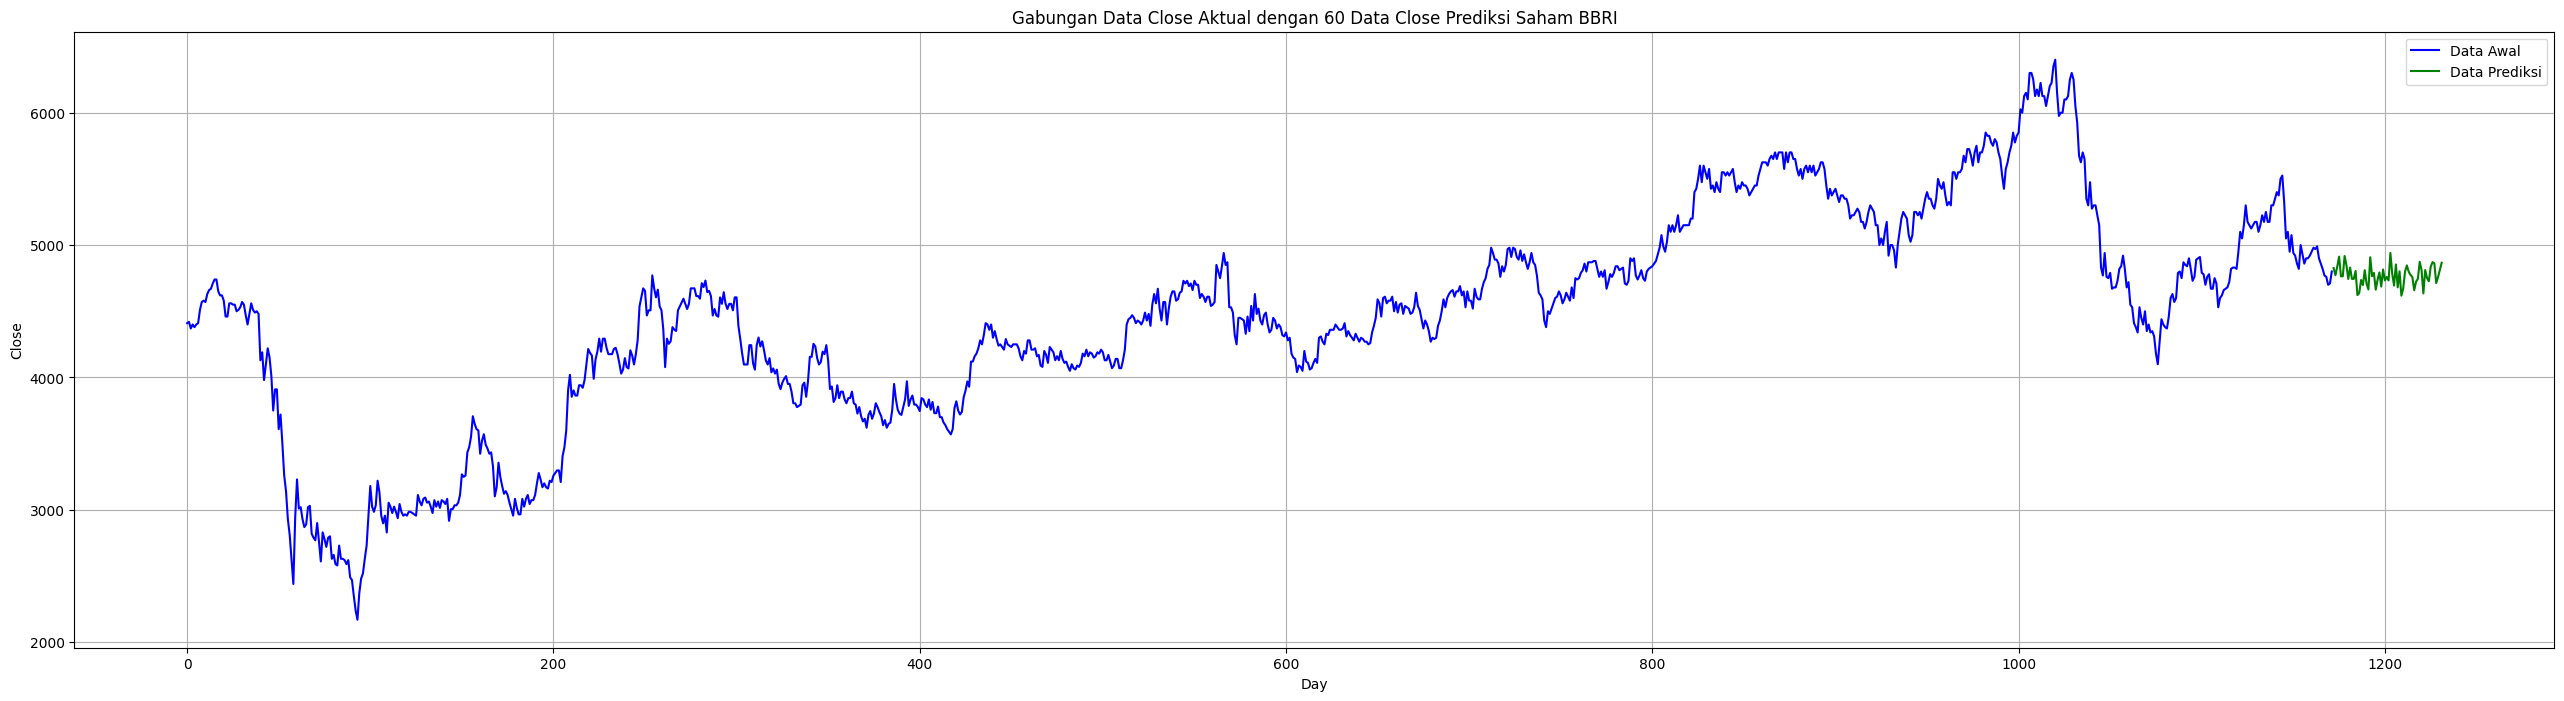

In [31]:
future_df['Day'] = range(len(df), len(df) + 60)
# Gabungan data sebelumnya dengan prediksi masa depan
combined_df = pd.concat([
    pd.DataFrame({'Day': range(len(df)), 'Close': df['Close']}),
    future_df.rename(columns={'Future Predictions': 'Close'})
], ignore_index=True)

plt.figure(figsize=(32, 8))
plt.plot(combined_df['Day'][:len(df)], combined_df['Close'][:len(df)], label='Data Awal', color='blue')
plt.plot(combined_df['Day'][len(df):], combined_df['Close'][len(df):], label='Data Prediksi', color='green') #, marker='o')
plt.title('Gabungan Data Close Aktual dengan 60 Data Close Prediksi Saham BBRI')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Simpan prediksi masa depan ke DataFrame
future_df.to_excel('future_predictions.xlsx', index=False)
print("\nPrediksi 60 Data ke Depan disimpan ke 'future_predictions.xlsx'")


Prediksi 60 Data ke Depan disimpan ke 'future_predictions.xlsx'
